In [1]:
import pandas  as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
import keras
from keras import backend as K
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU, PReLU, ELU, ThresholdedReLU
from keras.layers import Dropout, BatchNormalization
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 2. Deep Networks

Se cargan los datos y se generan las matrices a trabajar.

In [2]:
df_sets = pd.read_csv("./koi_sets_unb.csv")
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_clean = (df_sets["Set"] != "Unlabeled").values
df_labels = pd.read_csv("./koi_labels.csv")
df_X = pd.read_csv("./koi_light_curves_X.csv")
df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]
df_X_train = df_X[mask_train]
df_X_test = df_X[mask_test]
df_X_clean = df_X[mask_clean]

y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_X_train = df_X_train.reset_index(drop=True)
df_X_test = df_X_test.reset_index(drop=True)
df_X_train.fillna(df_X_train.median(), inplace=True)
df_X_test.fillna(df_X_test.median(), inplace=True)
X_train = df_X_train.values[:,1:]
X_test = df_X_test.values[:,1:]


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

**a) RED SHALLOW** 

In [3]:
#modelo
model = Sequential()
model.add(Dense(1280, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.01),loss='binary_crossentropy', metrics=['accuracy']) #compilar

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.binary_crossentropy(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 0s 111us/step - loss: 0.6431 - acc: 0.6286 - val_loss: 0.6449 - val_acc: 0.5495
Epoch 2/50
3753/3753 [==============================] - 0s 71us/step - loss: 0.5986 - acc: 0.6643 - val_loss: 0.6310 - val_acc: 0.5474
Epoch 3/50
3753/3753 [==============================] - 0s 74us/step - loss: 0.5665 - acc: 0.6880 - val_loss: 0.6265 - val_acc: 0.5474
Epoch 4/50
3753/3753 [==============================] - 0s 97us/step - loss: 0.5342 - acc: 0.7226 - val_loss: 0.5781 - val_acc: 0.6006
Epoch 5/50
3753/3753 [==============================] - 0s 79us/step - loss: 0.5053 - acc: 0.7557 - val_loss: 0.5246 - val_acc: 0.7614
Epoch 6/50
3753/3753 [==============================] - 0s 73us/step - loss: 0.4819 - acc: 0.7836 - val_loss: 0.4961 - val_acc: 0.8435
Epoch 7/50
3753/3753 [

Gradientes previo al entrenamiento:


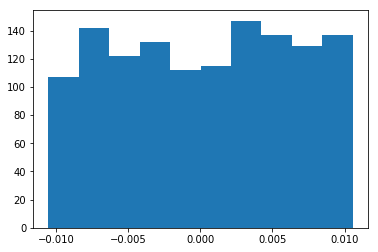

Gradientes posterior al entrenamiento:


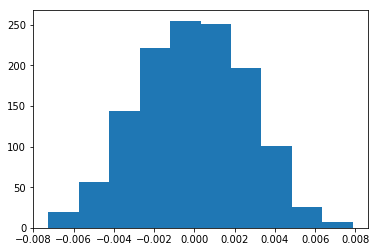

Comparacion de gradientes:


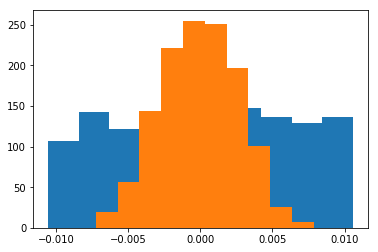

In [4]:
print("Gradientes previo al entrenamiento:")
plt.hist(evaluated_gradients[1])
plt.show()
print("Gradientes posterior al entrenamiento:")
plt.hist(final_evaluated_gradients[1])
plt.show()
print("Comparacion de gradientes:")
plt.hist(evaluated_gradients[1])
plt.hist(final_evaluated_gradients[1])
plt.show()

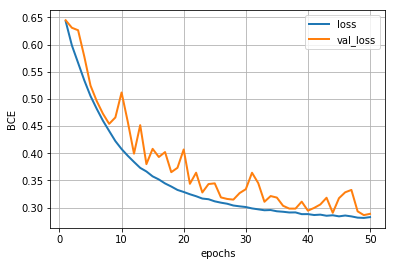

In [5]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

En cada iteración la red neuronal actualiza cada peso en proporción a la grdiente de la función objetivo, pero cuando la gradiente es demasiado pequeña y deja de generar cambio en los pesos estos se estancan generando un problema. En los peores casos, dado el problema recien mencionado la red puede dejar de "aprender". En los histogramas se puede ver que las gradientes posterior al entrenamiento solo disminuyen en un orden de magnitud, esto debido justamente al problema de las gradientes descendientes explicado anteriormente.

**b) RED PROFUNDA UNIFORM DE 6 CAPAS**

In [6]:
#modelo
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.binary_crossentropy(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 1s 257us/step - loss: 0.6566 - acc: 0.6363 - val_loss: 0.7007 - val_acc: 0.5474
Epoch 2/50
3753/3753 [==============================] - 1s 170us/step - loss: 0.6553 - acc: 0.6400 - val_loss: 0.7003 - val_acc: 0.5474
Epoch 3/50
3753/3753 [==============================] - 1s 176us/step - loss: 0.6546 - acc: 0.6400 - val_loss: 0.7004 - val_acc: 0.5474
Epoch 4/50
3753/3753 [==============================] - 1s 198us/step - loss: 0.6545 - acc: 0.6400 - val_loss: 0.7087 - val_acc: 0.5474
Epoch 5/50
3753/3753 [==============================] - 1s 155us/step - loss: 0.6549 - acc: 0.6400 - val_loss: 0.7012 - val_acc: 0.5474
Epoch 6/50
3753/3753 [==============================] - 1s 183us/step - loss: 0.6550 - acc: 0.6400 - val_loss: 0.7189 - val_acc: 0.5474
Epoch 7/50
3753/3753 [==============================] - 1s 217us/step - loss: 0.6548 - acc: 0.6400 - val_loss: 0.7049 - val_acc: 0.5474
E

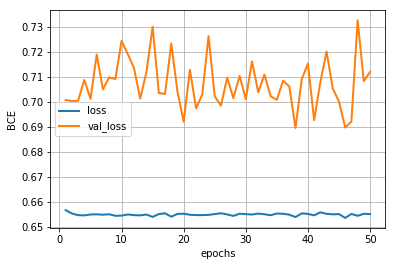

In [7]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

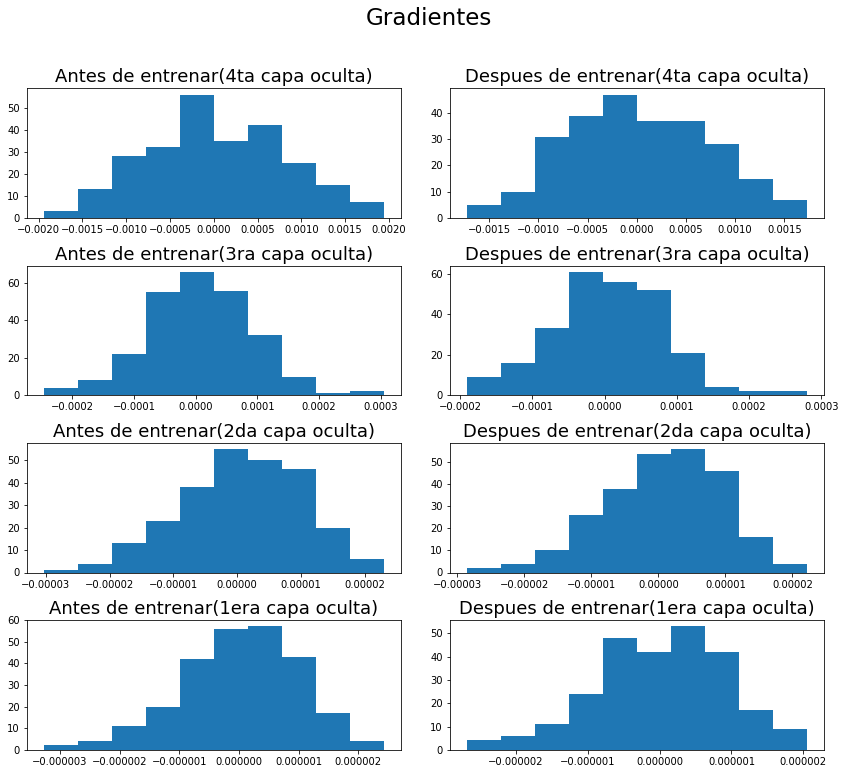

In [8]:
plt.figure(1, figsize=(12,10))
plt.suptitle("Gradientes", fontsize=23, y=1.07)

plt.subplot(421)
plt.title("Antes de entrenar(4ta capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[7])

plt.subplot(422)
plt.title("Despues de entrenar(4ta capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[7])

plt.subplot(423)
plt.title("Antes de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[5])

plt.subplot(424)
plt.title("Despues de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[5])

plt.subplot(425)
plt.title("Antes de entrenar(2da capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[3])

plt.subplot(426)
plt.title("Despues de entrenar(2da capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[3])

plt.subplot(427)
plt.title("Antes de entrenar(1era capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[1])

plt.subplot(428)
plt.title("Despues de entrenar(1era capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[1])

plt.tight_layout()
plt.show()

En esta red profunda se puede ver la presencia del problema de la gradiente desvaneciente en casi todas las capas de la red, pues, después de 50 epoch, los ordenes de magnitud disminuyen en un orden de magnitud, excepto en la segunda capa oculta. Entonces, la red no mejoró su rendimiento y no aprendio en comparación a la perdida.

**c) REF PROFUNDA GLOROT UNIFORM DE 6 CAPAS**

In [9]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.binary_crossentropy(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 1s 284us/step - loss: 0.6548 - acc: 0.6400 - val_loss: 0.6997 - val_acc: 0.5474
Epoch 2/50
3753/3753 [==============================] - 1s 186us/step - loss: 0.6546 - acc: 0.6400 - val_loss: 0.7248 - val_acc: 0.5474
Epoch 3/50
3753/3753 [==============================] - 1s 189us/step - loss: 0.6554 - acc: 0.6400 - val_loss: 0.6890 - val_acc: 0.5474
Epoch 4/50
3753/3753 [==============================] - 1s 194us/step - loss: 0.6554 - acc: 0.6400 - val_loss: 0.6901 - val_acc: 0.5474
Epoch 5/50
3753/3753 [==============================] - 1s 185us/step - loss: 0.6555 - acc: 0.6400 - val_loss: 0.7259 - val_acc: 0.5474
Epoch 6/50
3753/3753 [==============================] - 1s 197us/step - loss: 0.6547 - acc: 0.6400 - val_loss: 0.6983 - val_acc: 0.5474
Epoch 7/50
3753/3753 [==============================] - 1s 148us/step - loss: 0.6553 - acc: 0.6400 - val_loss: 0.7332 - val_acc: 0.5474
E

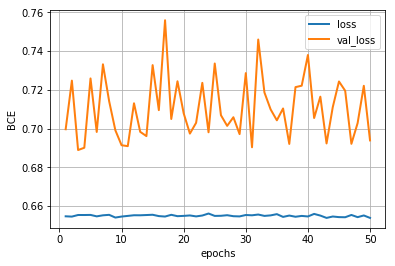

In [10]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

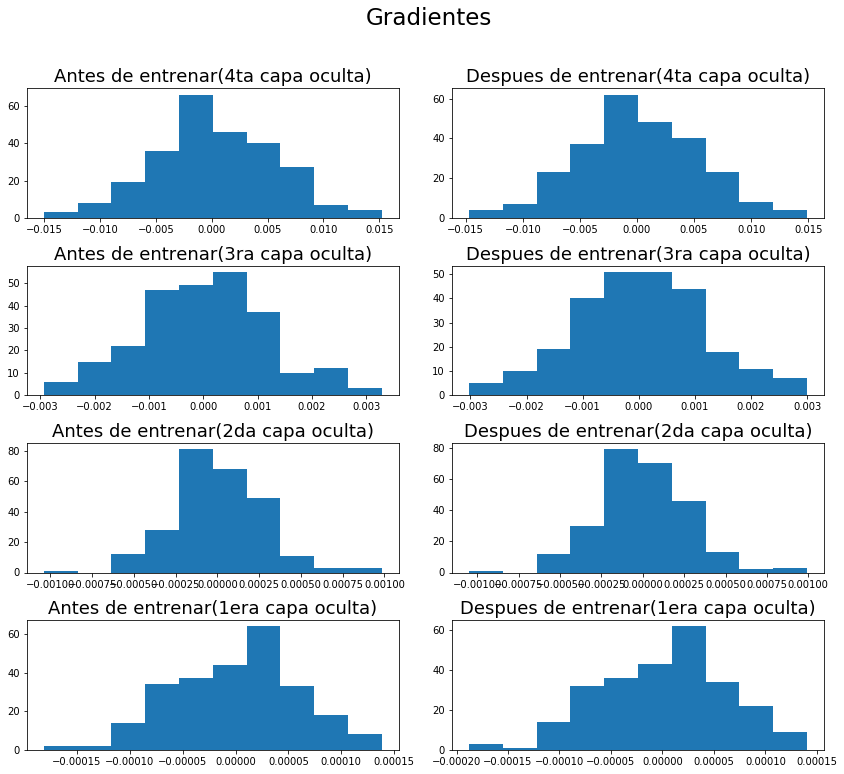

In [11]:
plt.figure(1, figsize=(12,10))
plt.suptitle("Gradientes", fontsize=23, y=1.07)

plt.subplot(421)
plt.title("Antes de entrenar(4ta capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[7])

plt.subplot(422)
plt.title("Despues de entrenar(4ta capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[7])

plt.subplot(423)
plt.title("Antes de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[5])

plt.subplot(424)
plt.title("Despues de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[5])

plt.subplot(425)
plt.title("Antes de entrenar(2da capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[3])

plt.subplot(426)
plt.title("Despues de entrenar(2da capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[3])

plt.subplot(427)
plt.title("Antes de entrenar(1era capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[1])

plt.subplot(428)
plt.title("Despues de entrenar(1era capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[1])

plt.tight_layout()
plt.show()

En este caso el modelo tampoco logra aprender, se puede ver reflejado en el graficos de la función loss, además entre una capa y otra la gradiente varía máximo en un orden de magnitud.

**d) RED PROFUNDA ACTIVACIÓN RELU DE 6 CAPAS**

In [12]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.binary_crossentropy(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 1s 292us/step - loss: 0.6830 - acc: 0.6392 - val_loss: 0.6887 - val_acc: 0.5474
Epoch 2/50
3753/3753 [==============================] - 1s 179us/step - loss: 0.6693 - acc: 0.6400 - val_loss: 0.6890 - val_acc: 0.5474
Epoch 3/50
3753/3753 [==============================] - 1s 153us/step - loss: 0.6618 - acc: 0.6400 - val_loss: 0.6914 - val_acc: 0.5474
Epoch 4/50
3753/3753 [==============================] - 1s 157us/step - loss: 0.6576 - acc: 0.6400 - val_loss: 0.6942 - val_acc: 0.5474
Epoch 5/50
3753/3753 [==============================] - 1s 175us/step - loss: 0.6554 - acc: 0.6400 - val_loss: 0.6967 - val_acc: 0.5474
Epoch 6/50
3753/3753 [==============================] - 1s 181us/step - loss: 0.6542 - acc: 0.6400 - val_loss: 0.6988 - val_acc: 0.5474
Epoch 7/50
3753/3753 [==============================] - 1s 158us/step - loss: 0.6535 - acc: 0.6400 - val_loss: 0.7005 - val_acc: 0.5474
E

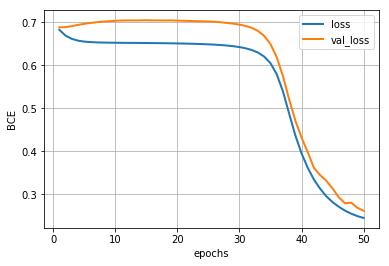

In [13]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

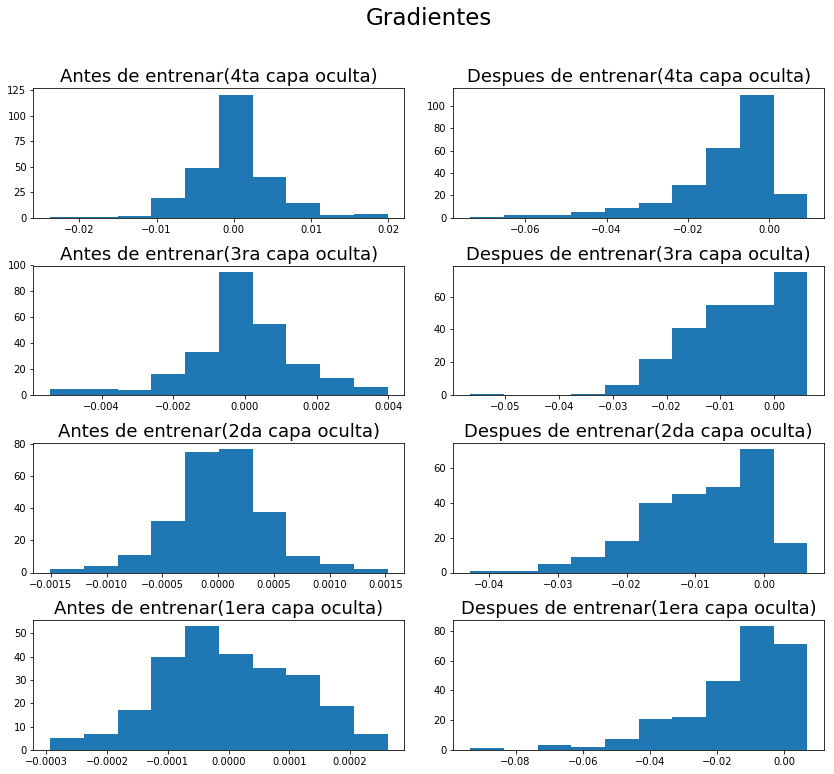

In [14]:
plt.figure(1, figsize=(12,10))
plt.suptitle("Gradientes", fontsize=23, y=1.07)

plt.subplot(421)
plt.title("Antes de entrenar(4ta capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[7])

plt.subplot(422)
plt.title("Despues de entrenar(4ta capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[7])

plt.subplot(423)
plt.title("Antes de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[5])

plt.subplot(424)
plt.title("Despues de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[5])

plt.subplot(425)
plt.title("Antes de entrenar(2da capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[3])

plt.subplot(426)
plt.title("Despues de entrenar(2da capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[3])

plt.subplot(427)
plt.title("Antes de entrenar(1era capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[1])

plt.subplot(428)
plt.title("Despues de entrenar(1era capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[1])

plt.tight_layout()
plt.show()

A pesar de que RELU sea conocida como la función de activación mas adecuada para tratar el problema de las gradientes, se puede ver que no logró manejar la gradientes en esta red y se puede ver en los histogramas y en el gráfico loss que en efecto la red no logra aprender.
Se puede apreciar que post el entrenamiento, las gradientes se concentran cercanas a 0, esto indica que el estado de la gradiente desvaneciente se mantiene

**inicializacion he uniform**

In [15]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.binary_crossentropy(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 1s 338us/step - loss: 0.3392 - acc: 0.8500 - val_loss: 0.8299 - val_acc: 0.6667
Epoch 2/50
3753/3753 [==============================] - 1s 166us/step - loss: 0.2820 - acc: 0.8812 - val_loss: 0.2867 - val_acc: 0.8690
Epoch 3/50
3753/3753 [==============================] - 1s 163us/step - loss: 0.2619 - acc: 0.8820 - val_loss: 0.2614 - val_acc: 0.8786
Epoch 4/50
3753/3753 [==============================] - 1s 216us/step - loss: 0.2532 - acc: 0.8897 - val_loss: 0.2467 - val_acc: 0.8956
Epoch 5/50
3753/3753 [==============================] - 1s 219us/step - loss: 0.2435 - acc: 0.8926 - val_loss: 0.5671 - val_acc: 0.7710
Epoch 6/50
3753/3753 [==============================] - 1s 189us/step - loss: 0.2438 - acc: 0.8908 - val_loss: 0.2410 - val_acc: 0.8978
Epoch 7/50
3753/3753 [==============================] - 1s 219us/step - loss: 0.2412 - acc: 0.8966 - val_loss: 0.2405 - val_acc: 0.8903
E

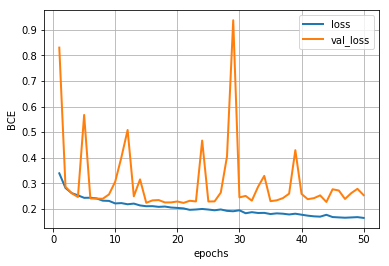

In [16]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

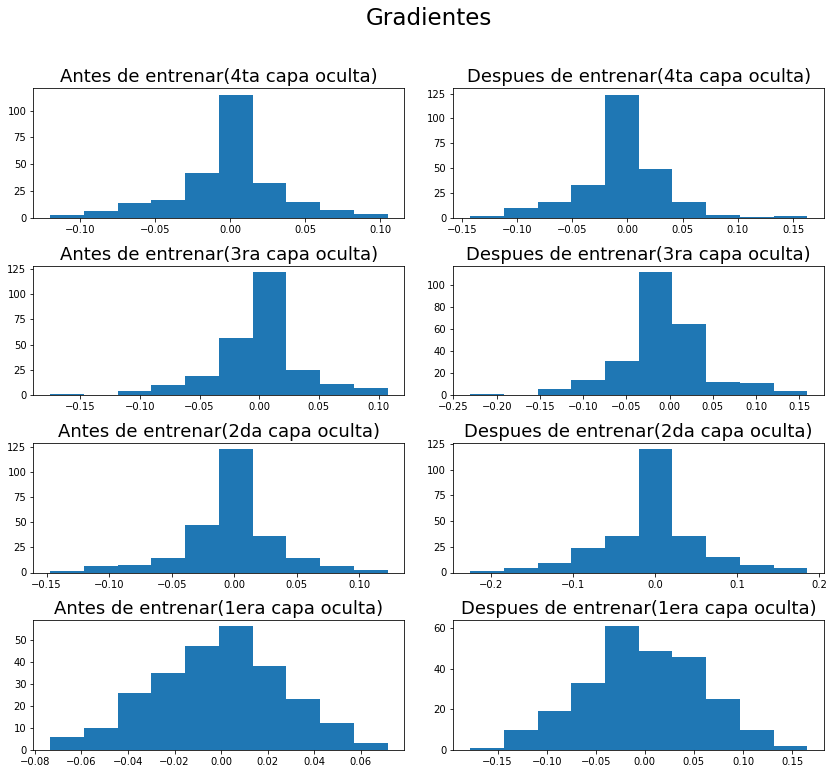

In [17]:
plt.figure(1, figsize=(12,10))
plt.suptitle("Gradientes", fontsize=23, y=1.07)

plt.subplot(421)
plt.title("Antes de entrenar(4ta capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[7])

plt.subplot(422)
plt.title("Despues de entrenar(4ta capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[7])

plt.subplot(423)
plt.title("Antes de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[5])

plt.subplot(424)
plt.title("Despues de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[5])

plt.subplot(425)
plt.title("Antes de entrenar(2da capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[3])

plt.subplot(426)
plt.title("Despues de entrenar(2da capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[3])

plt.subplot(427)
plt.title("Antes de entrenar(1era capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[1])

plt.subplot(428)
plt.title("Despues de entrenar(1era capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[1])

plt.tight_layout()
plt.show()

Usando el inicializador he_uniform, se puede ver que las gradientes no tienen ningun cambio en la red antes de ser entrenada, sin embargo, post entrenamiento la red si presencia el problema de las gradientes desvanecientes, se puede ver que la variación de las gradientes entre las ultimas capas es de un orden de magnitud..

**e) REF PROFUNDA INICIALIZADA HE UNIFORM CON ACTIVACIÓN SOFTPLUS DE 6 CAPAS****

In [18]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.binary_crossentropy(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 1s 309us/step - loss: 0.5339 - acc: 0.7285 - val_loss: 0.3874 - val_acc: 0.8200
Epoch 2/50
3753/3753 [==============================] - 1s 168us/step - loss: 0.3372 - acc: 0.8503 - val_loss: 0.4425 - val_acc: 0.7636
Epoch 3/50
3753/3753 [==============================] - 1s 171us/step - loss: 0.3143 - acc: 0.8561 - val_loss: 0.6563 - val_acc: 0.6954
Epoch 4/50
3753/3753 [==============================] - 1s 171us/step - loss: 0.3028 - acc: 0.8628 - val_loss: 0.2884 - val_acc: 0.8690
Epoch 5/50
3753/3753 [==============================] - 1s 171us/step - loss: 0.3116 - acc: 0.8577 - val_loss: 0.2784 - val_acc: 0.8860
Epoch 6/50
3753/3753 [==============================] - 1s 171us/step - loss: 0.2919 - acc: 0.8694 - val_loss: 0.4469 - val_acc: 0.7721
Epoch 7/50
3753/3753 [==============================] - 1s 170us/step - loss: 0.2849 - acc: 0.8796 - val_loss: 0.2623 - val_acc: 0.8967
E

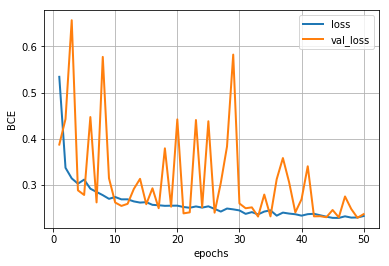

In [19]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

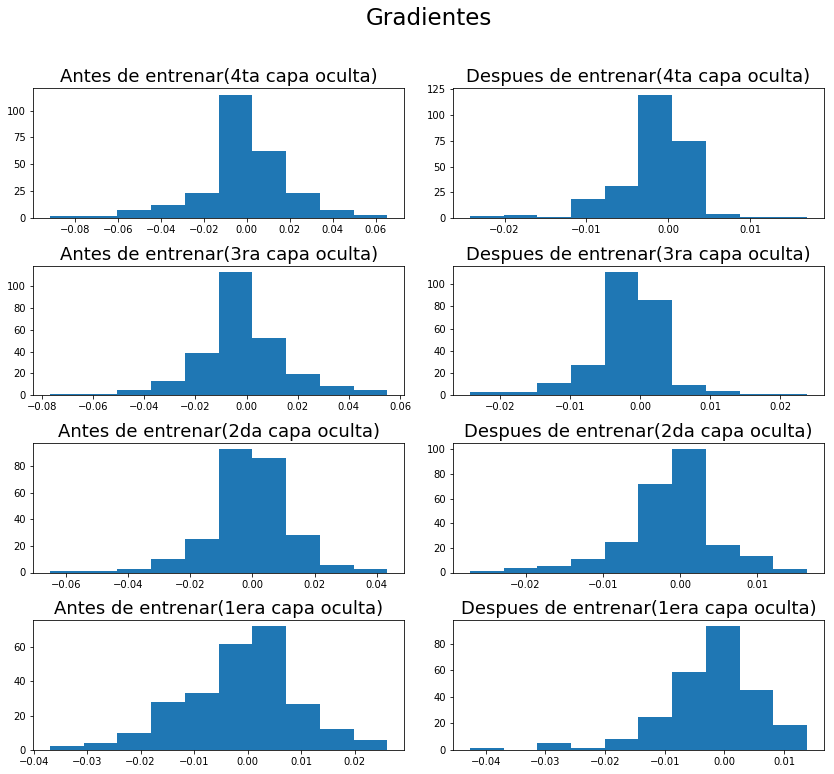

In [20]:
plt.figure(1, figsize=(12,10))
plt.suptitle("Gradientes", fontsize=23, y=1.07)

plt.subplot(421)
plt.title("Antes de entrenar(4ta capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[7])

plt.subplot(422)
plt.title("Despues de entrenar(4ta capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[7])

plt.subplot(423)
plt.title("Antes de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[5])

plt.subplot(424)
plt.title("Despues de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[5])

plt.subplot(425)
plt.title("Antes de entrenar(2da capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[3])

plt.subplot(426)
plt.title("Despues de entrenar(2da capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[3])

plt.subplot(427)
plt.title("Antes de entrenar(1era capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[1])

plt.subplot(428)
plt.title("Despues de entrenar(1era capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[1])

plt.tight_layout()
plt.show()

Al igual que en las redes anteriores, el problema de los gradientes se mantiene para los pesos de la red post entrenamiento y se puede verificar en la función loss que la función no logra aprender.

**f) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento?**

Con mayor profundidad en la red, el problema de las gradientes desvanecientes se acentua más, por ende, es más dificil de manejar, de todas formas, este problema podría ser trabajado según los parámetros utilizados, la función de activación y el inicializador escogidos.

**Variación de los parámetros para un mejor aprendizaje usando la familia RELU**

#### LEAKYRELU

In [29]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation=LeakyReLU(alpha=0.3)))
model.add(Dense(256, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(256, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(256, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(256, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.mean_squared_error(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 2s 474us/step - loss: 0.5593 - acc: 0.6608 - val_loss: 0.5154 - val_acc: 0.7082
Epoch 2/50
3753/3753 [==============================] - 1s 171us/step - loss: 0.4104 - acc: 0.8359 - val_loss: 0.3899 - val_acc: 0.8541
Epoch 3/50
3753/3753 [==============================] - 1s 188us/step - loss: 0.3220 - acc: 0.8772 - val_loss: 0.3235 - val_acc: 0.8743
Epoch 4/50
3753/3753 [==============================] - 1s 179us/step - loss: 0.2834 - acc: 0.8854 - val_loss: 0.2987 - val_acc: 0.8839
Epoch 5/50
3753/3753 [==============================] - 1s 169us/step - loss: 0.2683 - acc: 0.8884 - val_loss: 0.2792 - val_acc: 0.8914
Epoch 6/50
3753/3753 [==============================] - 1s 177us/step - loss: 0.2592 - acc: 0.8913 - val_loss: 0.2704 - val_acc: 0.8914
Epoch 7/50
3753/3753 [==============================] - 1s 204us/step - loss: 0.2531 - acc: 0.8958 - val_loss: 0.2715 - val_acc: 0.8882
E

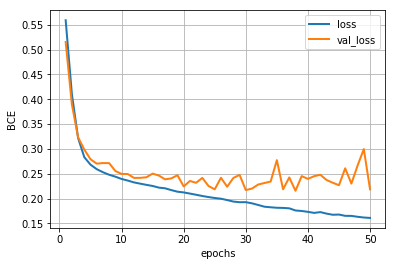

In [30]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

#### PRELU

In [31]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation=PReLU(alpha_initializer='zeros')))
model.add(Dense(256, activation=PReLU(alpha_initializer='zeros')))
model.add(Dense(256, activation=PReLU(alpha_initializer='zeros')))
model.add(Dense(256, activation=PReLU(alpha_initializer='zeros')))
model.add(Dense(256, activation=PReLU(alpha_initializer='zeros')))
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.mean_squared_error(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 2s 531us/step - loss: 0.5917 - acc: 0.6392 - val_loss: 0.5744 - val_acc: 0.5474
Epoch 2/50
3753/3753 [==============================] - 1s 195us/step - loss: 0.4705 - acc: 0.7543 - val_loss: 0.4549 - val_acc: 0.8179
Epoch 3/50
3753/3753 [==============================] - 1s 197us/step - loss: 0.3657 - acc: 0.8662 - val_loss: 0.3626 - val_acc: 0.8679
Epoch 4/50
3753/3753 [==============================] - 1s 197us/step - loss: 0.3017 - acc: 0.8796 - val_loss: 0.3131 - val_acc: 0.8818
Epoch 5/50
3753/3753 [==============================] - 1s 253us/step - loss: 0.2742 - acc: 0.8897 - val_loss: 0.2943 - val_acc: 0.8839
Epoch 6/50
3753/3753 [==============================] - 1s 208us/step - loss: 0.2608 - acc: 0.8908 - val_loss: 0.2937 - val_acc: 0.8818
Epoch 7/50
3753/3753 [==============================] - 1s 209us/step - loss: 0.2541 - acc: 0.8937 - val_loss: 0.2745 - val_acc: 0.8924
E

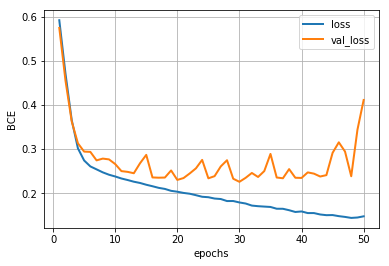

In [32]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

#### ELU

In [33]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation=ELU(alpha=1.0)))
model.add(Dense(256, activation=ELU(alpha=1.0)))
model.add(Dense(256, activation=ELU(alpha=1.0)))
model.add(Dense(256, activation=ELU(alpha=1.0)))
model.add(Dense(256, activation=ELU(alpha=1.0)))
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.mean_squared_error(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 2s 571us/step - loss: 0.3895 - acc: 0.8542 - val_loss: 0.3038 - val_acc: 0.8850
Epoch 2/50
3753/3753 [==============================] - 1s 208us/step - loss: 0.2812 - acc: 0.8793 - val_loss: 0.2748 - val_acc: 0.8882
Epoch 3/50
3753/3753 [==============================] - 1s 215us/step - loss: 0.2663 - acc: 0.8881 - val_loss: 0.2753 - val_acc: 0.8818
Epoch 4/50
3753/3753 [==============================] - 1s 184us/step - loss: 0.2594 - acc: 0.8892 - val_loss: 0.2635 - val_acc: 0.8882
Epoch 5/50
3753/3753 [==============================] - 1s 210us/step - loss: 0.2537 - acc: 0.8921 - val_loss: 0.2774 - val_acc: 0.8754
Epoch 6/50
3753/3753 [==============================] - 1s 208us/step - loss: 0.2506 - acc: 0.8937 - val_loss: 0.2505 - val_acc: 0.8903
Epoch 7/50
3753/3753 [==============================] - 1s 209us/step - loss: 0.2485 - acc: 0.8961 - val_loss: 0.2531 - val_acc: 0.8850
E

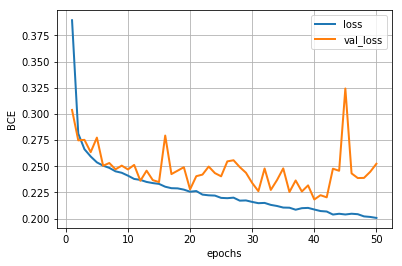

In [34]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

#### ThresholdedReLU

In [35]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation=ThresholdedReLU(theta=1.0)))
model.add(Dense(256, activation=ThresholdedReLU(theta=1.0)))
model.add(Dense(256, activation=ThresholdedReLU(theta=1.0)))
model.add(Dense(256, activation=ThresholdedReLU(theta=1.0)))
model.add(Dense(256, activation=ThresholdedReLU(theta=1.0)))
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.mean_squared_error(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 2s 559us/step - loss: 0.6850 - acc: 0.6368 - val_loss: 0.6894 - val_acc: 0.5453
Epoch 2/50
3753/3753 [==============================] - 1s 209us/step - loss: 0.6707 - acc: 0.6390 - val_loss: 0.6897 - val_acc: 0.5463
Epoch 3/50
3753/3753 [==============================] - 1s 193us/step - loss: 0.6633 - acc: 0.6395 - val_loss: 0.6914 - val_acc: 0.5463
Epoch 4/50
3753/3753 [==============================] - 1s 185us/step - loss: 0.6590 - acc: 0.6395 - val_loss: 0.6938 - val_acc: 0.5463
Epoch 5/50
3753/3753 [==============================] - 1s 189us/step - loss: 0.6563 - acc: 0.6398 - val_loss: 0.6962 - val_acc: 0.5463
Epoch 6/50
3753/3753 [==============================] - 1s 201us/step - loss: 0.6550 - acc: 0.6400 - val_loss: 0.6983 - val_acc: 0.5463
Epoch 7/50
3753/3753 [==============================] - 1s 186us/step - loss: 0.6540 - acc: 0.6400 - val_loss: 0.7000 - val_acc: 0.5474
E

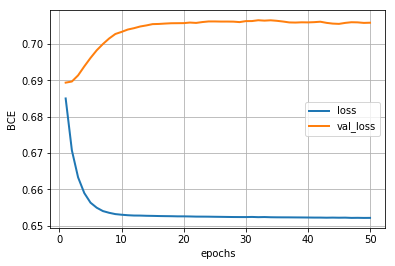

In [36]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

* ¿Con cuál se aprende más rápido en términos de la *loss*?

En función de la loss aprende más rápido con la activación PReLU.

**g)**

In [39]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])

###calculate gradients

y_train_t = tf.convert_to_tensor(y_train, np.float32)
y_train_t = tf.reshape(y_train_t, [len(y_train),1])
loss = keras.losses.mean_squared_error(model.output,y_train_t)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.binary_crossentropy(model.output,y_train_t)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 2s 641us/step - loss: 0.4839 - acc: 0.7655 - val_loss: 0.3850 - val_acc: 0.8839
Epoch 2/50
3753/3753 [==============================] - 1s 205us/step - loss: 0.3122 - acc: 0.8718 - val_loss: 0.2945 - val_acc: 0.8914
Epoch 3/50
3753/3753 [==============================] - 1s 198us/step - loss: 0.2829 - acc: 0.8825 - val_loss: 0.2696 - val_acc: 0.8892
Epoch 4/50
3753/3753 [==============================] - 1s 221us/step - loss: 0.2584 - acc: 0.8932 - val_loss: 0.2485 - val_acc: 0.8946
Epoch 5/50
3753/3753 [==============================] - 1s 201us/step - loss: 0.2542 - acc: 0.8979 - val_loss: 0.2539 - val_acc: 0.8882
Epoch 6/50
3753/3753 [==============================] - 1s 206us/step - loss: 0.2437 - acc: 0.9019 - val_loss: 0.2416 - val_acc: 0.8935
Epoch 7/50
3753/3753 [

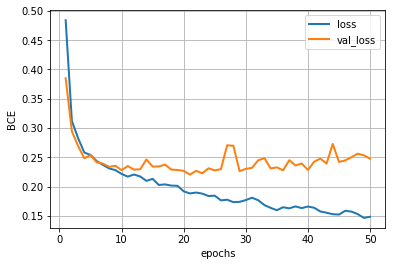

In [40]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('BCE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()